In [2]:
%%capture # suppress output
!pip install google-cloud-storage
!pip install pandas

In [48]:
import torch.utils.data
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.utils as vutils
from pathlib import Path
from google.cloud import storage

'''
Code taken partially from DCGAN tutorial
https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
'''


'\nCode taken partially from DCGAN tutorial\nhttps://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html\n'

In [60]:
# Load data into TMP from Cloud Bucket
!gsutil -m cp -r gs://gandinsky /tmp

UsageError: Line magic function `%%capture` not found.


In [62]:
#copy data from GCP buckets to local 
dataroot = Path('/tmp/gandinsky/dataset/') 


# Neural Net Hyperparams
options = {}
options['dataroot'] = str(dataroot) #location of training data
options['batch_size'] = 128  # Batch size during training
options['workers'] = 2       # Number of workers for dataloader
options['image_size'] = 64   # Training images. All images will be resized to this size using a transformer.
options['nc'] = 3     # Number of channels in the training images. Color = 3
options['nz'] = 100   # Size of z latent vector (i.e. size of generator input)
options['ngf'] = 64 # Size of feature maps in generator
options['ndf'] = 64 # Size of feature maps in discriminator
options['num_epochs'] = 10 # training loops
options['lr'] = .0002 # Learning rate for optimizers
options['beta1']  = 0.5  # Beta1 hyperparam for Adam optimizers
options['ngpu'] = 1 # Number of GPUs available. Use 0 for CPU mode.

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset using training images from WikiArt on Kandinsky paintings
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(options['image_size']),
                               transforms.CenterCrop(options['image_size']),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=options['batch_size'],
                                         shuffle=True, num_workers=options['workers'])

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and options['ngpu'] > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( options['nz'], options['ngf'] * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(options['ngf'] * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(options['ngf'] * 8, options['ngf'] * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(options['ngf'] * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( options['ngf'] * 4, options['ngf'] * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(options['ngf']* 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( options['ngf'] * 2, options['ngf'], 4, 2, 1, bias=False),
            nn.BatchNorm2d(options['ngf']),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( options['ngf'], options['nc'], 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [66]:
# Create the generator
netG = Generator(options['ngpu']).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (options['ngpu'] > 1):
    netG = nn.DataParallel(netG, list(range(options['ngpu'])))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [67]:
# Discriminator 

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(options['nc'], options['ndf'], 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(options['ndf'], options['ndf'] * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(options['ndf'] * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(options['ndf'] * 2, options['ndf'] * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(options['ndf'] * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(options['ndf'] * 4, options['ndf'] * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(options['ndf'] * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(options['ndf'] * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [68]:
# Create the Discriminator
netD = Discriminator(options['ngpu']).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (options['ngpu'] > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [69]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, options['nz'], 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=options['lr'], betas=(options['beta1'], 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=options['lr'], betas=(options['beta1'], 0.999))

In [70]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(options['num_epochs']):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, options['nz'], 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, options['num_epochs'], i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == options['num_epochs']-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/10][0/1]	Loss_D: 1.5396	Loss_G: 5.3377	D(x): 0.4738	D(G(z)): 0.4082 / 0.0069
[1/10][0/1]	Loss_D: 1.1481	Loss_G: 6.7126	D(x): 0.8569	D(G(z)): 0.5536 / 0.0025
[2/10][0/1]	Loss_D: 0.6364	Loss_G: 6.2441	D(x): 0.7194	D(G(z)): 0.2246 / 0.0029
[3/10][0/1]	Loss_D: 0.5393	Loss_G: 6.4487	D(x): 0.7934	D(G(z)): 0.2331 / 0.0025
[4/10][0/1]	Loss_D: 0.6415	Loss_G: 8.0133	D(x): 0.8609	D(G(z)): 0.3484 / 0.0005
[5/10][0/1]	Loss_D: 0.4873	Loss_G: 7.5614	D(x): 0.7799	D(G(z)): 0.1838 / 0.0008
[6/10][0/1]	Loss_D: 0.5313	Loss_G: 8.5447	D(x): 0.8436	D(G(z)): 0.2740 / 0.0003
[7/10][0/1]	Loss_D: 0.5264	Loss_G: 9.3989	D(x): 0.8282	D(G(z)): 0.2479 / 0.0002
[8/10][0/1]	Loss_D: 0.3673	Loss_G: 7.9782	D(x): 0.7990	D(G(z)): 0.1147 / 0.0005
[9/10][0/1]	Loss_D: 0.8100	Loss_G: 12.2664	D(x): 0.9031	D(G(z)): 0.4549 / 0.0000


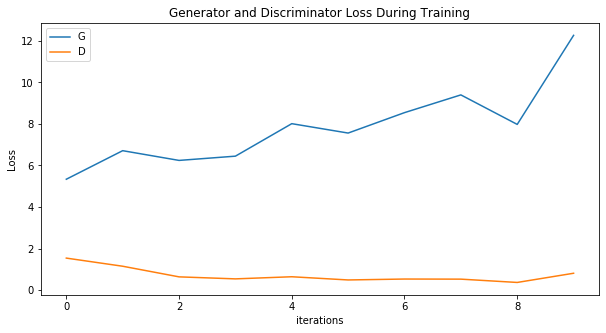

In [71]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

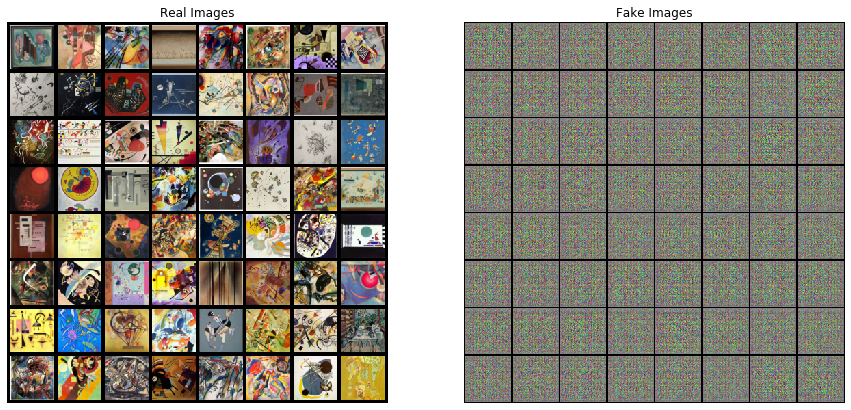

In [61]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
# Yikes! Time to figure out what went wrong here. 